In [1]:
import yaml
import matplotlib.pyplot as plt

In [2]:
SETTINGS = {
    'msg' : 'Generic Polymath analysis notebook',
    'filename' : 'Polymath',
    'source' : 'pm1', # insert here the polymath in focus
    'urls' : [],
    'type' : '', # this is probably redundant,
    'parser' : 'html5lib',
    'cmap' : plt.cm.Paired, # not a string, this is an object
    'vmin' : 1,
    'vmax' : 100
}

In [3]:
with open("author_convert.yaml", "r") as convert_file:
    CONVERT = yaml.safe_load(convert_file.read())

In [4]:
from bs4 import BeautifulSoup

with open("DATA/"+ SETTINGS['source'] + ".txt", "r") as input:
    SOUP = BeautifulSoup(input.readline())

print SOUP.prettify()

<html>
 <body>
  <h2>
   <span class="mw-headline" id="Threads_and_further_problems">
    Threads and further problems
   </span>
  </h2>
  <ul>
   <li>
    <a class="external text" href="http://gowers.wordpress.com/2009/01/27/is-massively-collaborative-mathematics-possible/" rel="nofollow">
     Is massively collaborative mathematics possible?
    </a>
    (inactive)
   </li>
   <li>
    (1-199)
    <a class="external text" href="http://gowers.wordpress.com/2009/02/01/a-combinatorial-approach-to-density-hales-jewett/" rel="nofollow">
     A combinatorial approach to density Hales-Jewett
    </a>
    (inactive)
   </li>
   <li>
    (200-299)
    <a class="external text" href="http://terrytao.wordpress.com/2009/02/05/upper-and-lower-bounds-for-the-density-hales-jewett-problem/" rel="nofollow">
     Upper and lower bounds for the density Hales-Jewett problem
    </a>
    (inactive)
   </li>
   <li>
    (300-399)
    <a class="external text" href="http://gowers.wordpress.com/2009/02/06/dh

In [5]:
from collections import OrderedDict
import json
from urlparse import urlparse

import pandas as pd
from pandas import DataFrame

ITEMS = SOUP.find("ul").find_all("li")
URLS = [item.find("a").get("href") for item in ITEMS]
TITLES = [item.text for item in ITEMS]

PM1_FRAME = DataFrame({
    'url': URLS,
    'title' : TITLES,
    'blog' : [urlparse(url).netloc[:-14].title() for url in URLS],
    'research' : [title.startswith(" (") for title in TITLES]},
    columns = ['title', 'url', 'blog', 'research'])

#index = pd.MultiIndex.from_tuples([('Polymath 1', i) for i in range(len(URLS))],
#                                      names=['Project', 'Ord'])
    
PM1_FRAME.iloc[0:5]

,title,url,blog,research
0,Is massively collaborative mathematics possib...,http://gowers.wordpress.com/2009/01/27/is-mass...,Gowers,False
1,(1-199) A combinatorial approach to density H...,http://gowers.wordpress.com/2009/02/01/a-combi...,Gowers,True
2,(200-299) Upper and lower bounds for the dens...,http://terrytao.wordpress.com/2009/02/05/upper...,Terrytao,True
3,(300-399) The triangle-removal approach (inac...,http://gowers.wordpress.com/2009/02/06/dhj-the...,Gowers,True
4,(400-499) Quasirandomness and obstructions to...,http://gowers.wordpress.com/2009/02/08/dhj-qua...,Gowers,True


In [6]:
from comment_thread import *
from author_network import *

THREAD_TYPES = {"Polymath": CommentThreadPolymath,
                "Gilkalai": CommentThreadGilkalai,
                "Gowers": CommentThreadGowers,
                "Terrytao": CommentThreadTerrytao}

PM1_FRAME['thread'] = [THREAD_TYPES[blog](url) for (url, blog) in zip(PM1_FRAME['url'], PM1_FRAME['blog'])]

In [7]:
PM1_FRAME['number of comments'] = PM1_FRAME['thread'].apply(lambda x: len(x.node_name.keys()))

PM1_FRAME.iloc[0:5]

,title,url,blog,research,thread,number of comments
0,Is massively collaborative mathematics possib...,http://gowers.wordpress.com/2009/01/27/is-mass...,Gowers,False,<comment_thread.CommentThreadGowers object at ...,75
1,(1-199) A combinatorial approach to density H...,http://gowers.wordpress.com/2009/02/01/a-combi...,Gowers,True,<comment_thread.CommentThreadGowers object at ...,181
2,(200-299) Upper and lower bounds for the dens...,http://terrytao.wordpress.com/2009/02/05/upper...,Terrytao,True,<comment_thread.CommentThreadTerrytao object a...,91
3,(300-399) The triangle-removal approach (inac...,http://gowers.wordpress.com/2009/02/06/dhj-the...,Gowers,True,<comment_thread.CommentThreadGowers object at ...,70
4,(400-499) Quasirandomness and obstructions to...,http://gowers.wordpress.com/2009/02/08/dhj-qua...,Gowers,True,<comment_thread.CommentThreadGowers object at ...,114


In [8]:
from pandas import Series

indices = PM1_FRAME.index
r_indices = PM1_FRAME[PM1_FRAME['research']].index
d_indices = PM1_FRAME[~PM1_FRAME['research']].index

threads = PM1_FRAME.thread
r_threads = PM1_FRAME[PM1_FRAME['research']].thread
d_threads = PM1_FRAME[~PM1_FRAME['research']].thread


# all threads
PM1_FRAME['mthread (single)'] = PM1_FRAME['thread'].apply(MultiCommentThread)
PM1_FRAME['mthread (accumulated)'] = Series([MultiCommentThread(*threads[0:i+1]) for i in indices],
                                            index=indices)
PM1_FRAME['network'] = PM1_FRAME['mthread (accumulated)'].apply(AuthorNetwork)

# only research
PM1_FRAME['r_mthread (accumulated)'] = Series([MultiCommentThread(*r_threads[0:i+1]) for i in r_indices],
                                               index=r_indices)
PM1_FRAME['r_network'] = PM1_FRAME[PM1_FRAME['research']]['r_mthread (accumulated)'].apply(AuthorNetwork)


# only discussion
PM1_FRAME['d_mthread (accumulated)'] = Series([MultiCommentThread(*d_threads[0:i+1]) for i in d_indices],
                    index=d_indices)
PM1_FRAME['d_network'] = PM1_FRAME[~PM1_FRAME['research']]['d_mthread (accumulated)'].apply(AuthorNetwork)

PM1_FRAME = PM1_FRAME.reindex_axis(['title', 'url', 'blog', 'research', 'number of comments',
                        'thread', 'mthread (single)',
                        'mthread (accumulated)', 'network',
                        'r_mthread (accumulated)', 'r_network',
                        'd_mthread (accumulated)', 'd_network'],
                        axis=1)


PM1_FRAME.index = pd.MultiIndex.from_tuples([('Polymath 1', i) for i in indices],
                                      names=['Project', 'Ord'])


PM1_FRAME



title  \
Project    Ord                                                      
Polymath 1 0     Is massively collaborative mathematics possib...   
           1     (1-199) A combinatorial approach to density H...   
           2     (200-299) Upper and lower bounds for the dens...   
           3     (300-399) The triangle-removal approach (inac...   
           4     (400-499) Quasirandomness and obstructions to...   
           5      (500-599) Possible proof strategies (inactive)    
           6     (600-699) A reading seminar on density Hales-...   
           7     (700-799) Bounds for the first few density Ha...   
           8      (800-849) Brief review of polymath1 (inactive)    
           9                (850-899) DHJ(3): 851-899 (inactive)    
           10    (900-999) DHJ(3): 900-999 (Density Hales-Jewe...   
           11    (1000-1049) Problem solved (probably) (inacti...   
           12    Polymath1 and open collaborative mathematics ...   
           13    (1050-1099) DHJ(3) and related results: 1050-...   
           14    (1100-1199) DHJ(3): 1100-1199 (Density Hales-...   
           15   (discussion) An Open Discussion and Polls: Aro...   
           16    (1200-1299) DHJ(k): 1200-1299 (Density Hales-...   
           17           DHJ: writing the second paper (inactive)    
           18     DHJ: still writing the second paper (inactive)    
           19          DHJ write-up and other matters (inactive)    
           20      DHJ: writing the second paper III. (inactive)    
           21    DHJ and Moser numbers: nearing the final draf...   

                                                              url      blog  \
Project    Ord                                                                
Polymath 1 0    http://gowers.wordpress.com/2009/01/27/is-mass...    Gowers   
           1    http://gowers.wordpress.com/2009/02/01/a-combi...    Gowers   
           2    http://terrytao.wordpress.com/2009/02/05/upper...  Terrytao   
           3    http://gowers.wordpress.com/2009/02/06/dhj-the...    Gowers   
           4    http://gowers.wordpress.com/2009/02/08/dhj-qua...    Gowers   
           5    http://gowers.wordpress.com/2009/02/13/dhj-pos...    Gowers   
           6    http://terrytao.wordpress.com/2009/02/11/a-rea...  Terrytao   
           7    http://terrytao.wordpress.com/2009/02/13/bound...  Terrytao   
           8    http://gowers.wordpress.com/2009/02/23/brief-r...    Gowers   
           9    http://gowers.wordpress.com/2009/03/02/dhj3-85...    Gowers   
           10   http://terrytao.wordpress.com/2009/03/04/dhj3-...  Terrytao   
           11   http://gowers.wordpress.com/2009/03/10/problem...    Gowers   
           12   http://gowers.wordpress.com/2009/03/10/polymat...    Gowers   
           13   http://gowers.wordpress.com/2009/03/16/dhj3-an...    Gowers   
           14   http://terrytao.wordpress.com/2009/03/14/dhj3-...  Terrytao   
           15   http://gilkalai.wordpress.com/2009/03/25/an-op...  Gilkalai   
           16   http://terrytao.wordpress.com/2009/03/30/dhjk-...  Terrytao   
           17   http://terrytao.wordpress.com/2009/05/22/dhj-w...  Terrytao   
           18   http://terrytao.wordpress.com/2009/06/14/dhj-s...  Terrytao   
           19   http://gowers.wordpress.com/2009/06/25/dhj-wri...    Gowers   
           20   http://terrytao.wordpress.com/2009/07/09/dhj-w...  Terrytao   
           21   http://terrytao.wordpress.com/2010/01/15/densi...  Terrytao   

               research  number of comments  \
Project    Ord                                
Polymath 1 0      False                  75   
           1       True                 181   
           2       True                  91   
           3       True                  70   
           4       True                 114   
           5       True                 114   
           6       True                  35   
           7       True                 102   
           8       True             

Show labels? (default = no) 


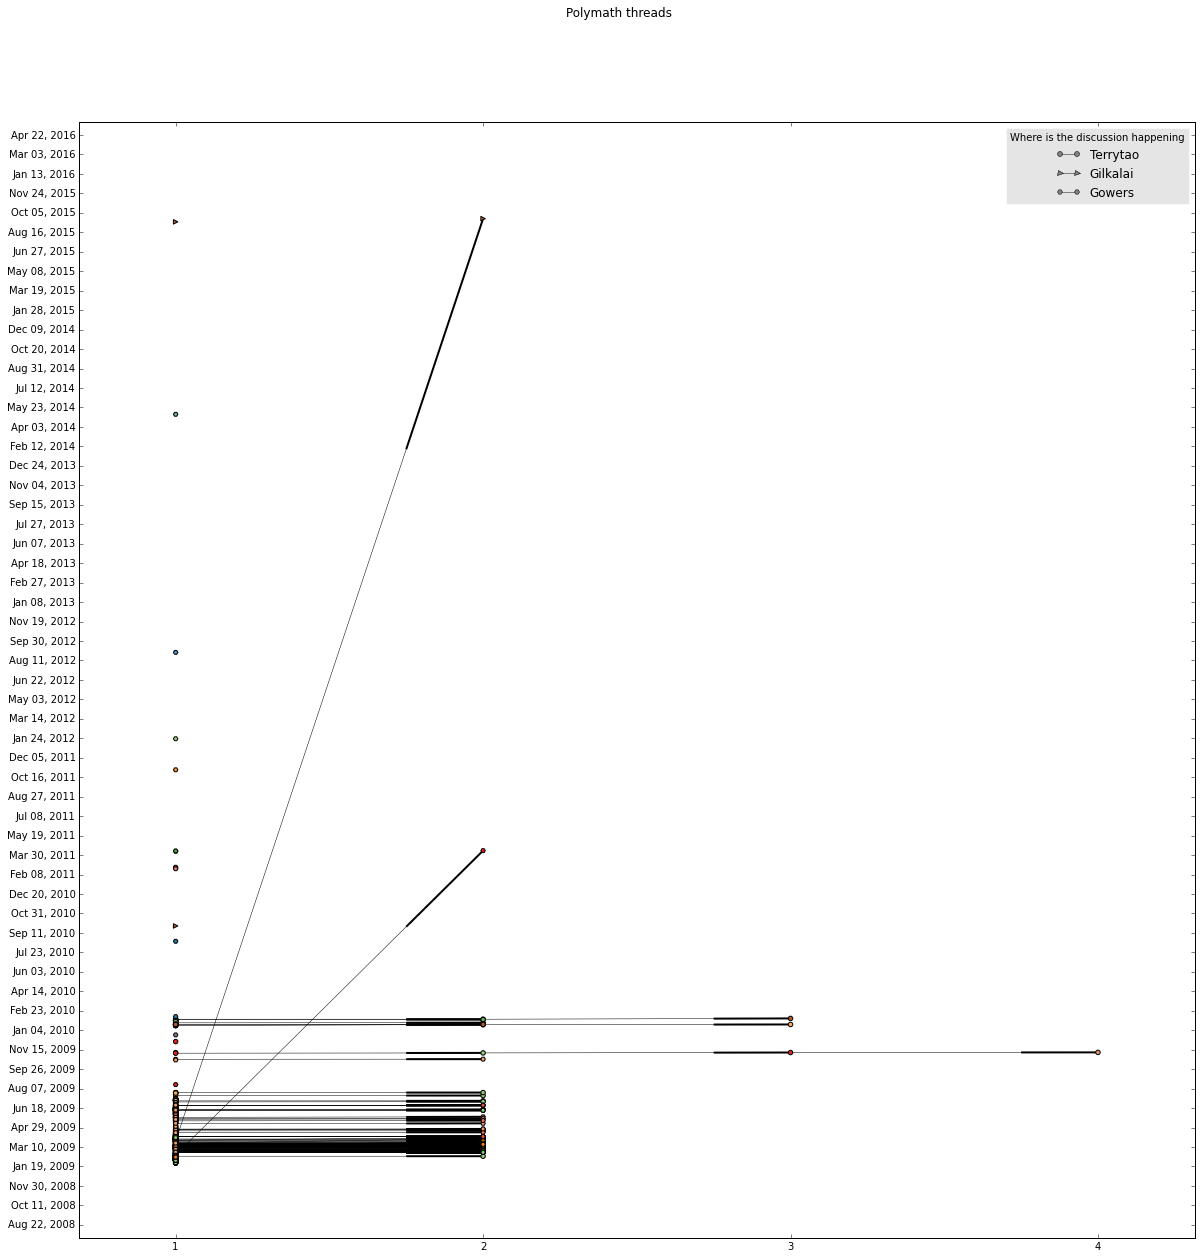

In [9]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 20)

PM1_FRAME['mthread (accumulated)'].iloc[-1].draw_graph(title="Polymath threads", time_intervals=50)

Show labels? (default = no) 


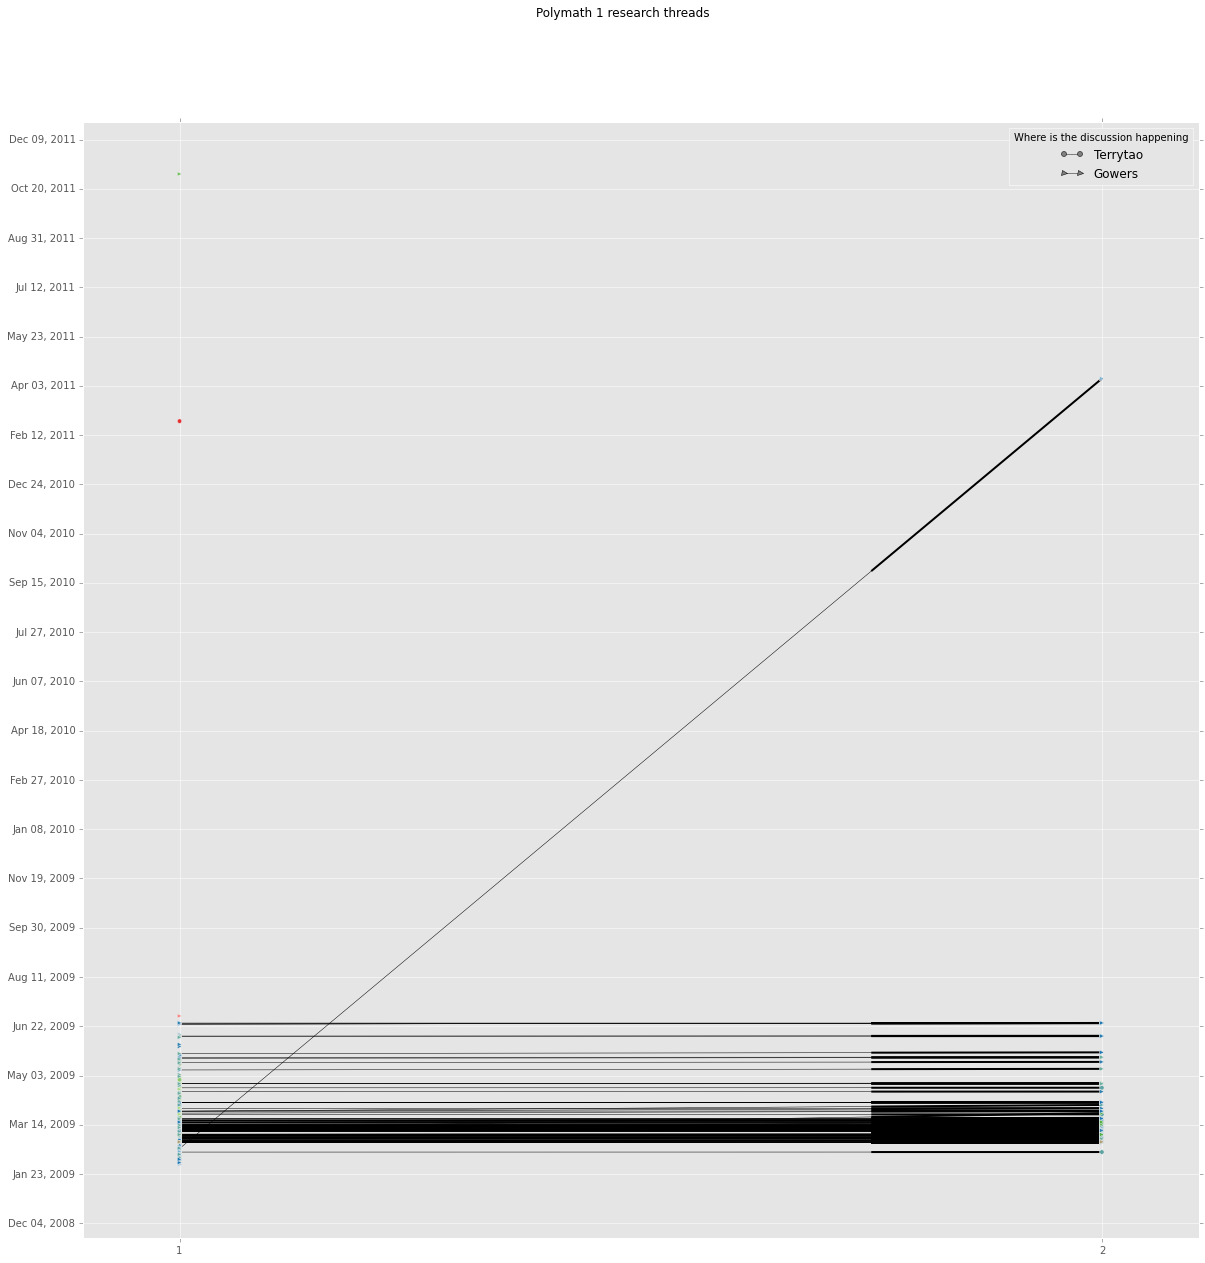

In [10]:
PM1_FRAME['r_mthread (accumulated)'].dropna().iloc[-1].draw_graph(title="Polymath 1 research threads", time_intervals=50)

Show labels? (default = no) 


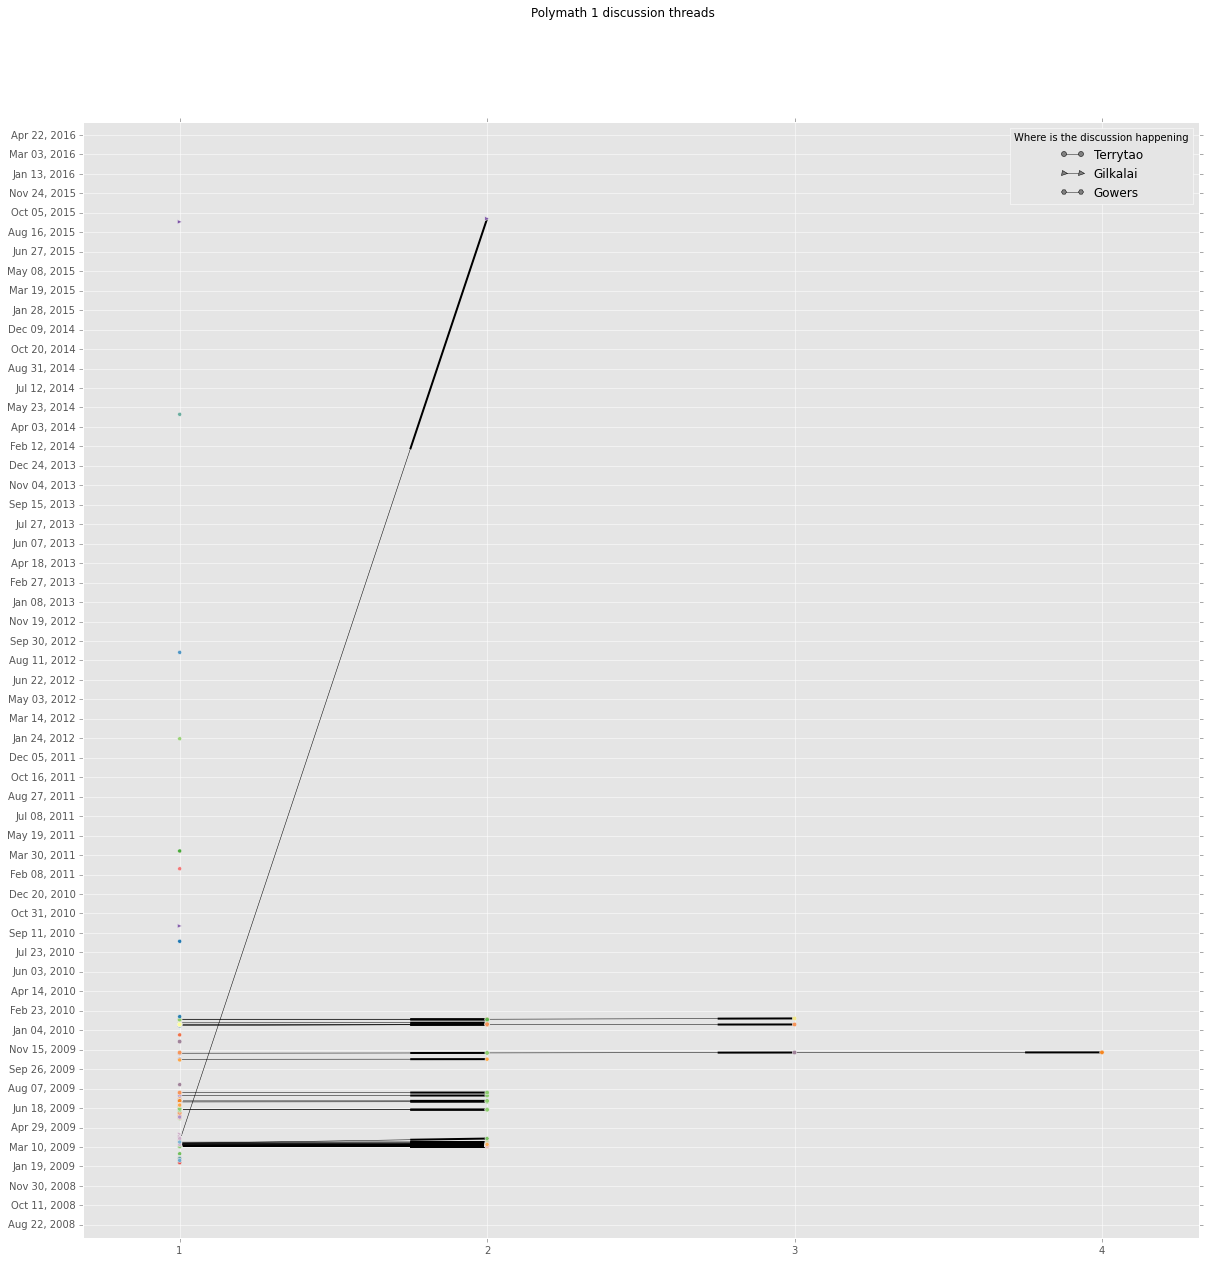

In [11]:
PM1_FRAME['d_mthread (accumulated)'].dropna().iloc[-1].draw_graph(title="Polymath 1 discussion threads", time_intervals=50)

Show labels? (default = yes) 


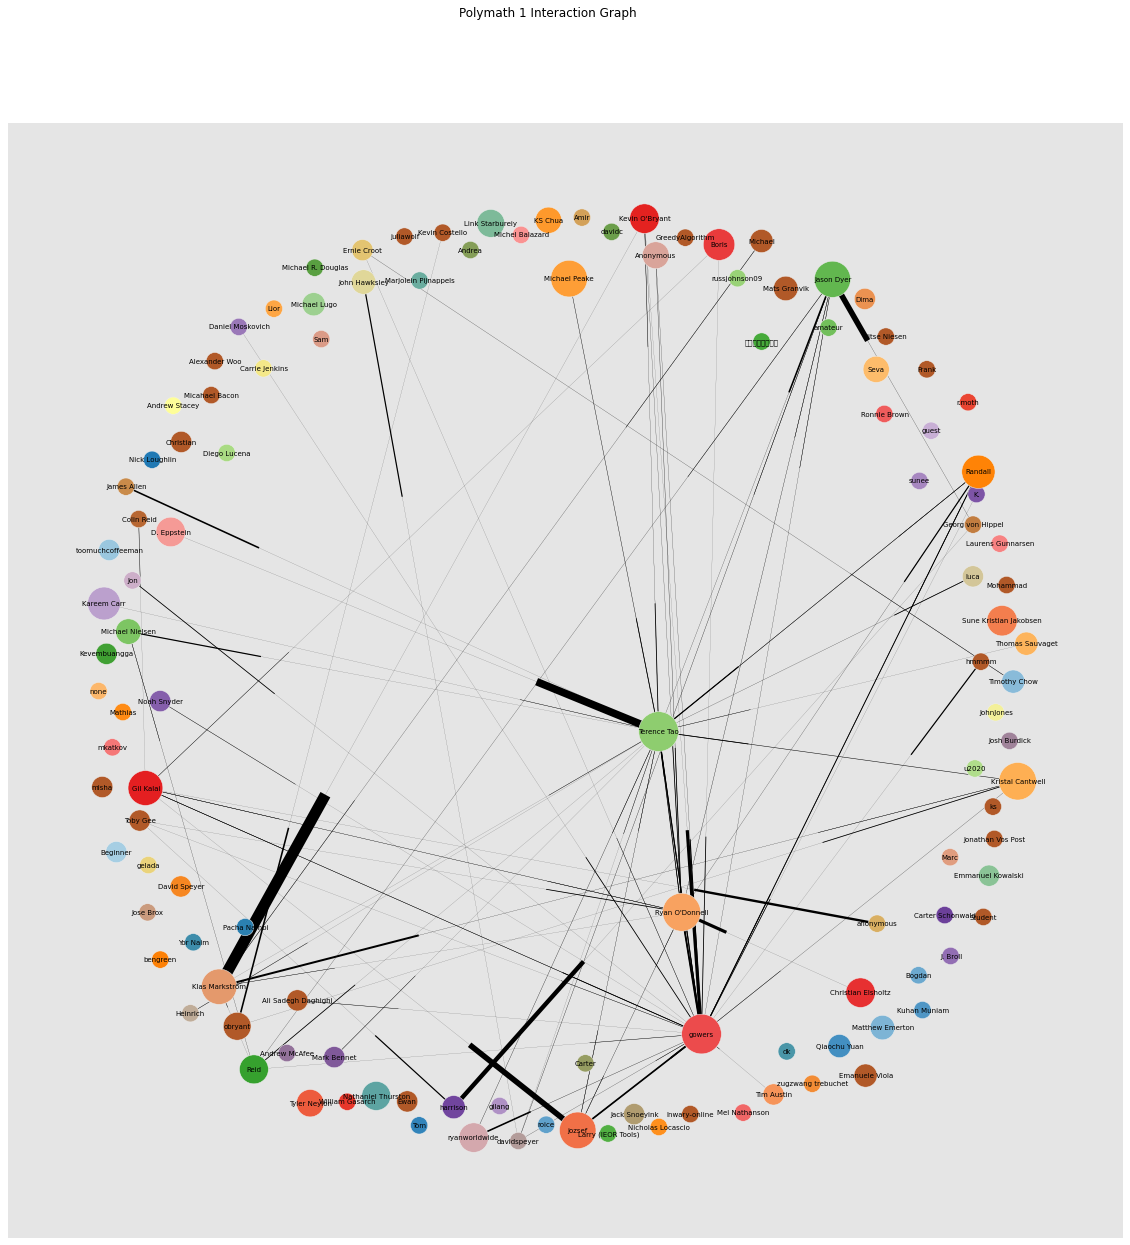

Show labels? (default = yes) 


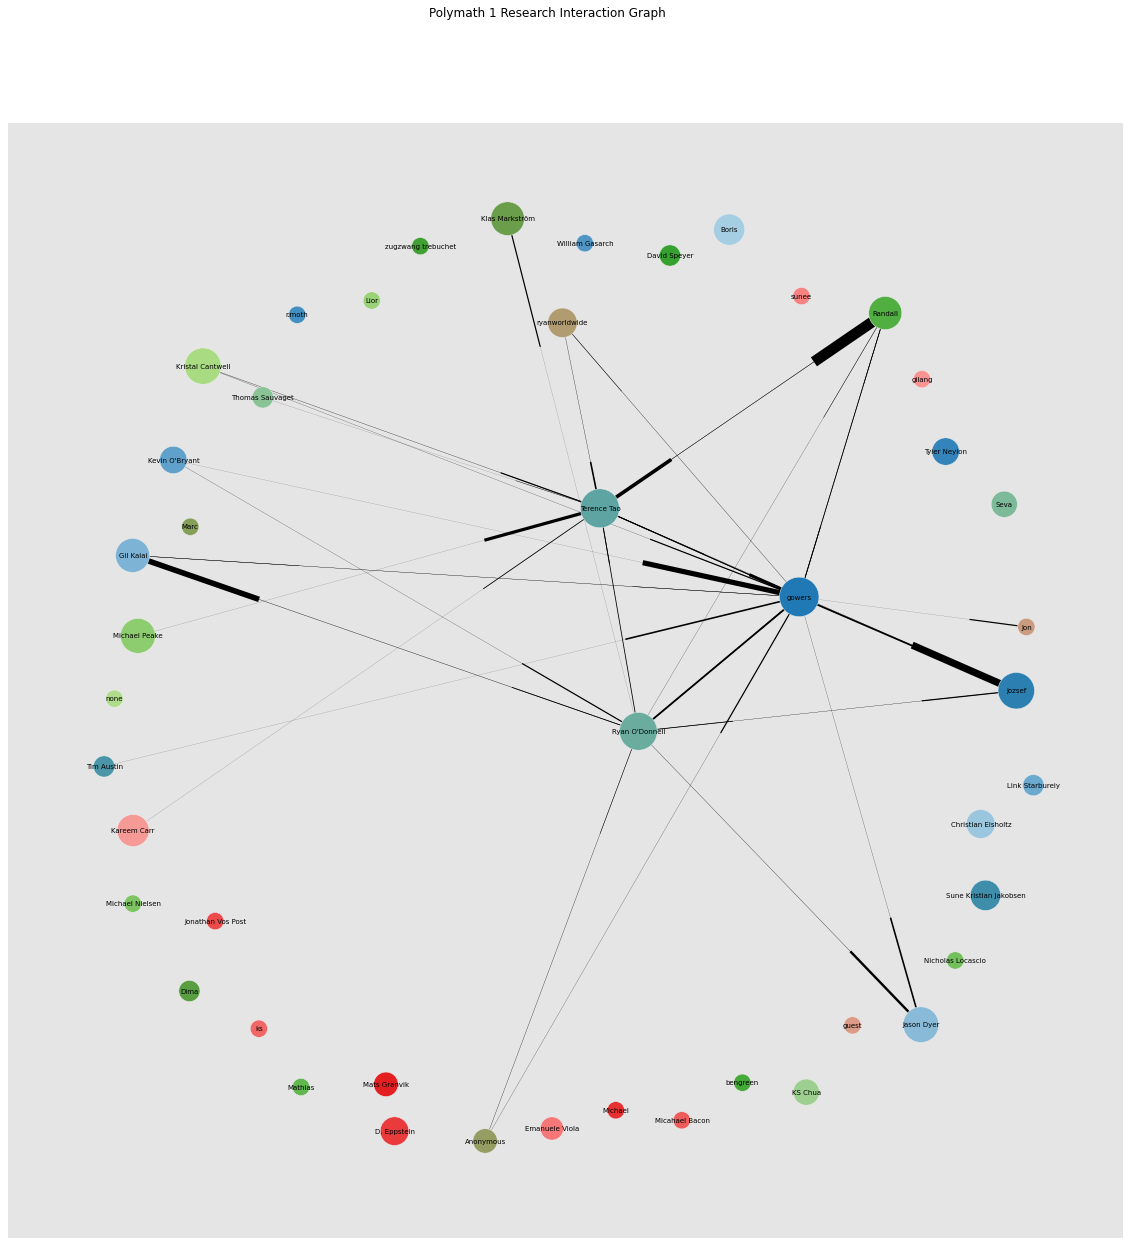

Show labels? (default = yes) 


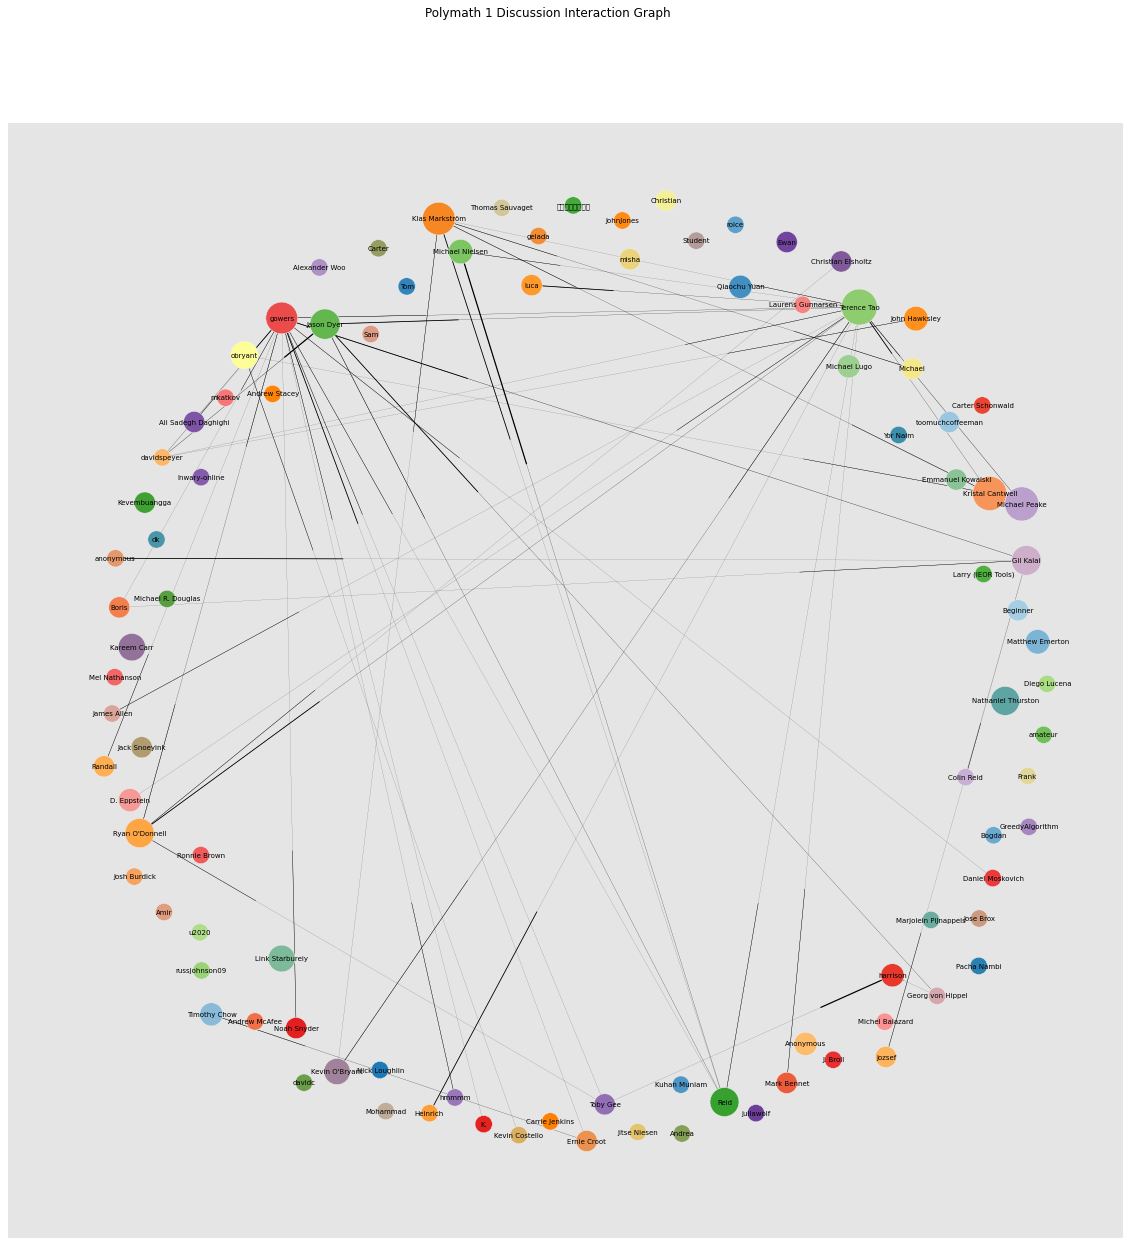

In [13]:
PM1_FRAME['network'].iloc[-1].draw_graph(title="Polymath 1 Interaction Graph")
PM1_FRAME['r_network'].dropna().iloc[-1].draw_graph(title="Polymath 1 Research Interaction Graph")
PM1_FRAME['d_network'].dropna().iloc[-1].draw_graph(title="Polymath 1 Discussion Interaction Graph")

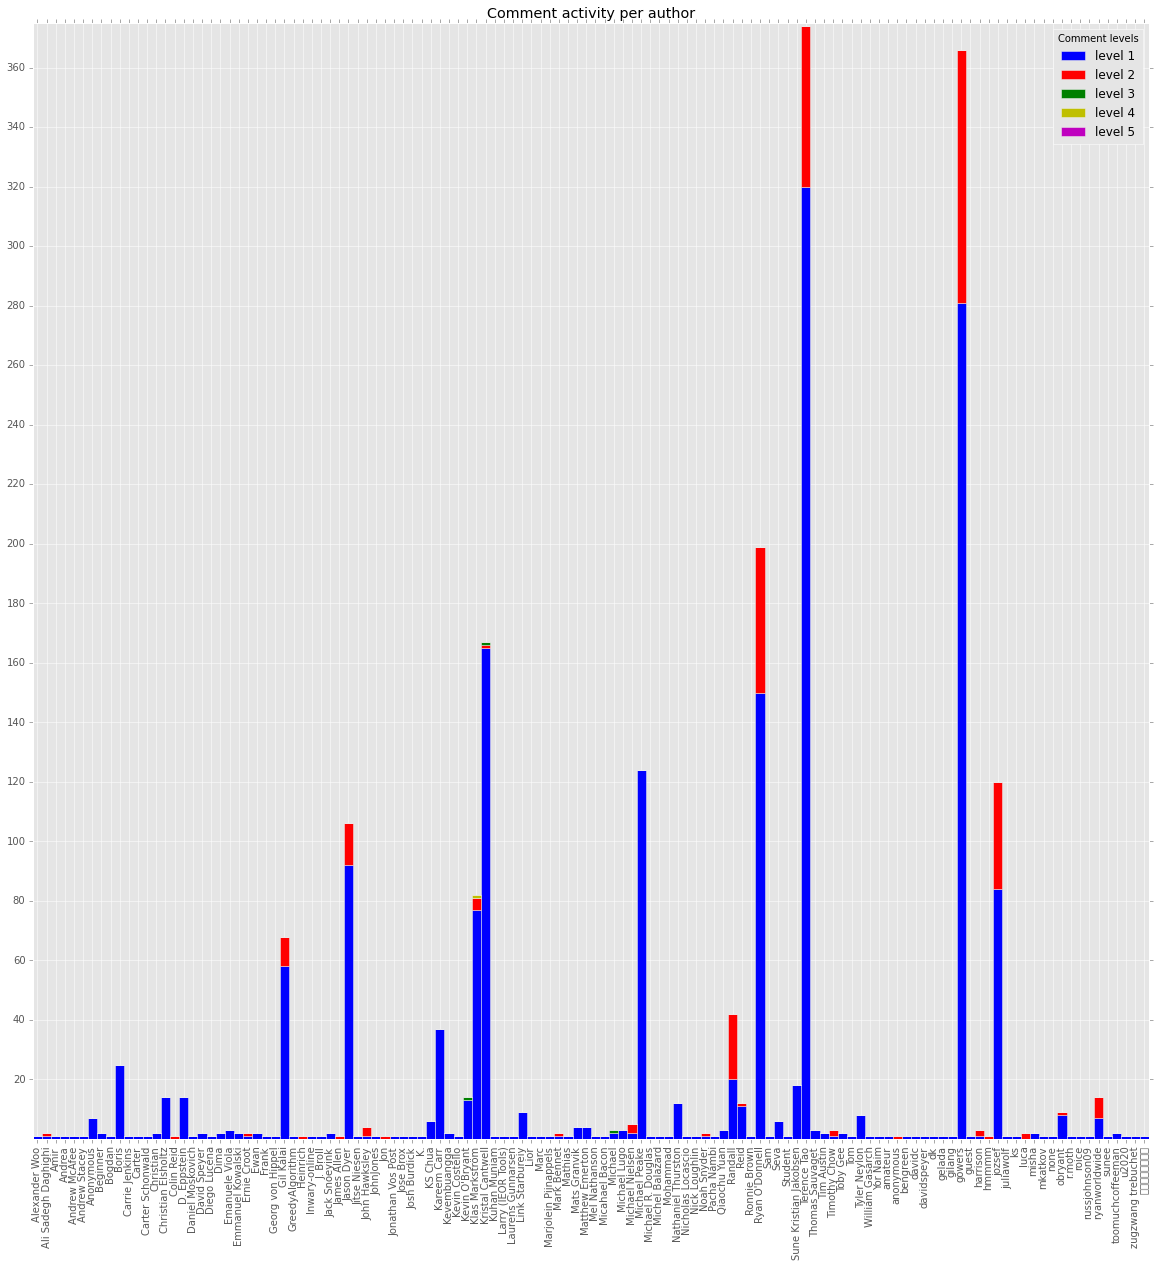

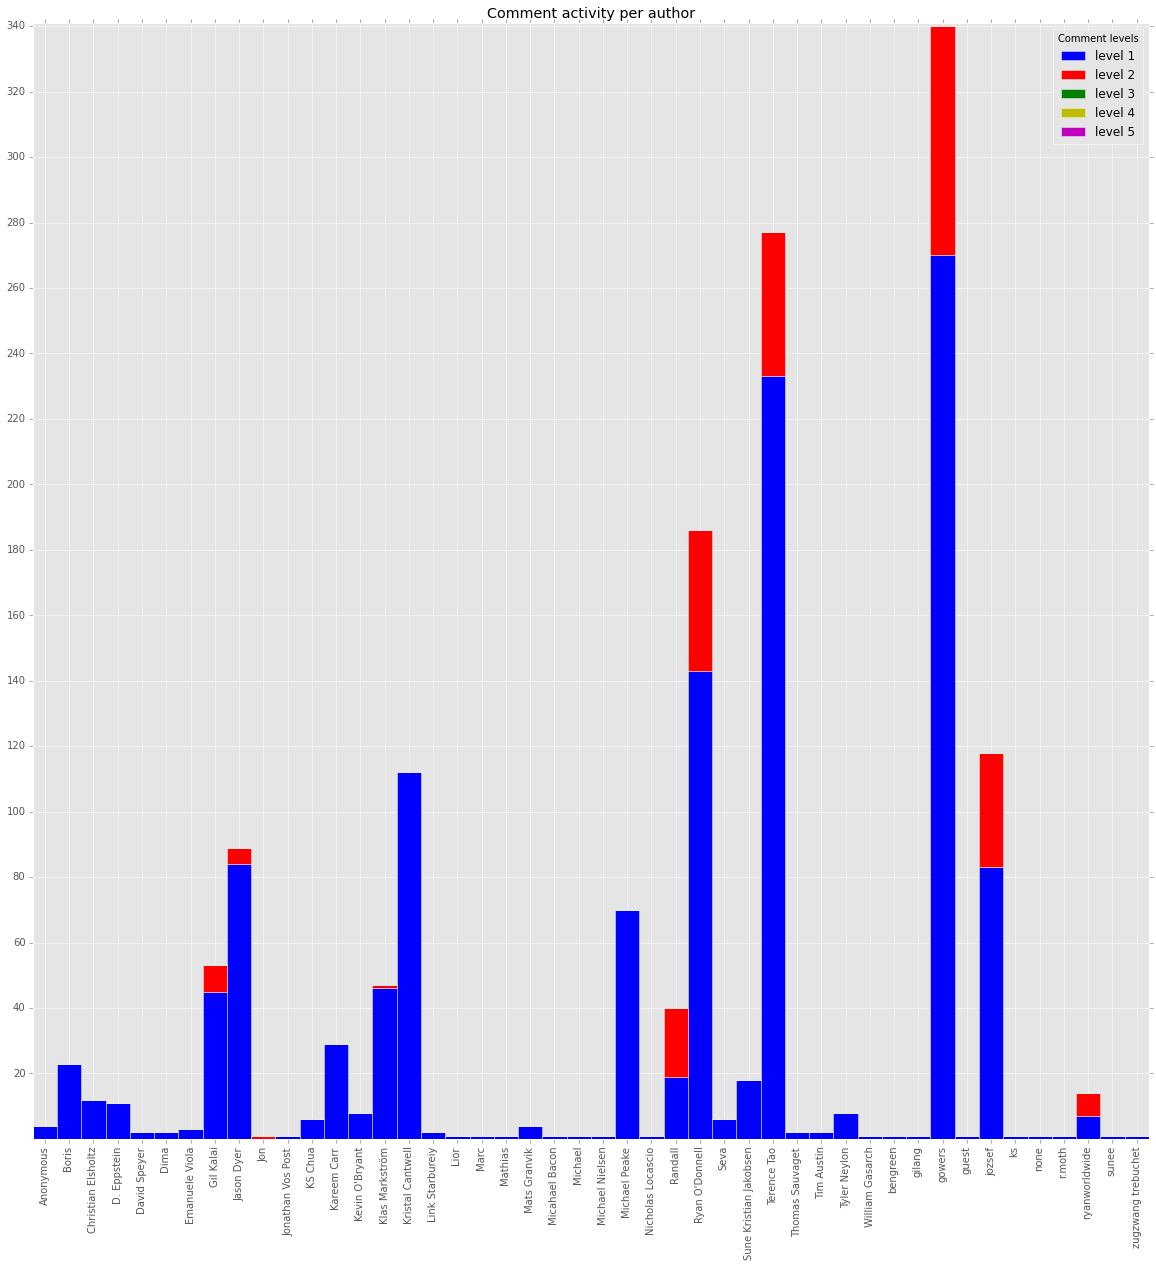

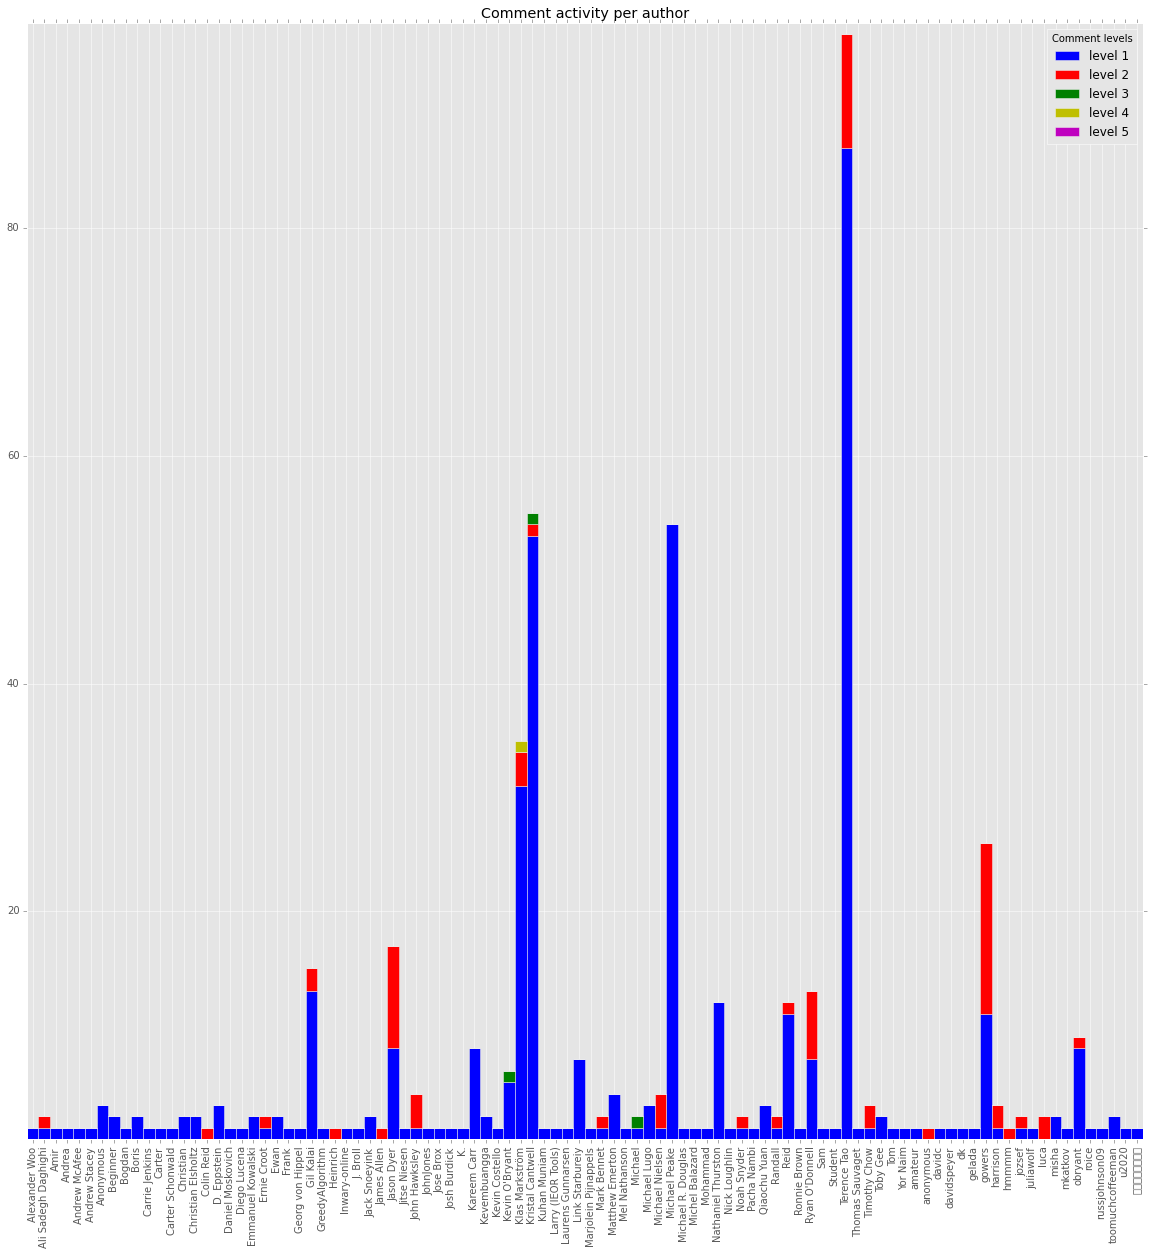

In [14]:
PM1_FRAME['network'].iloc[-1].plot_author_count(y_intervals=20)
PM1_FRAME['r_network'].dropna().iloc[-1].plot_author_count(y_intervals=20)
PM1_FRAME['d_network'].dropna().iloc[-1].plot_author_count(y_intervals=20)

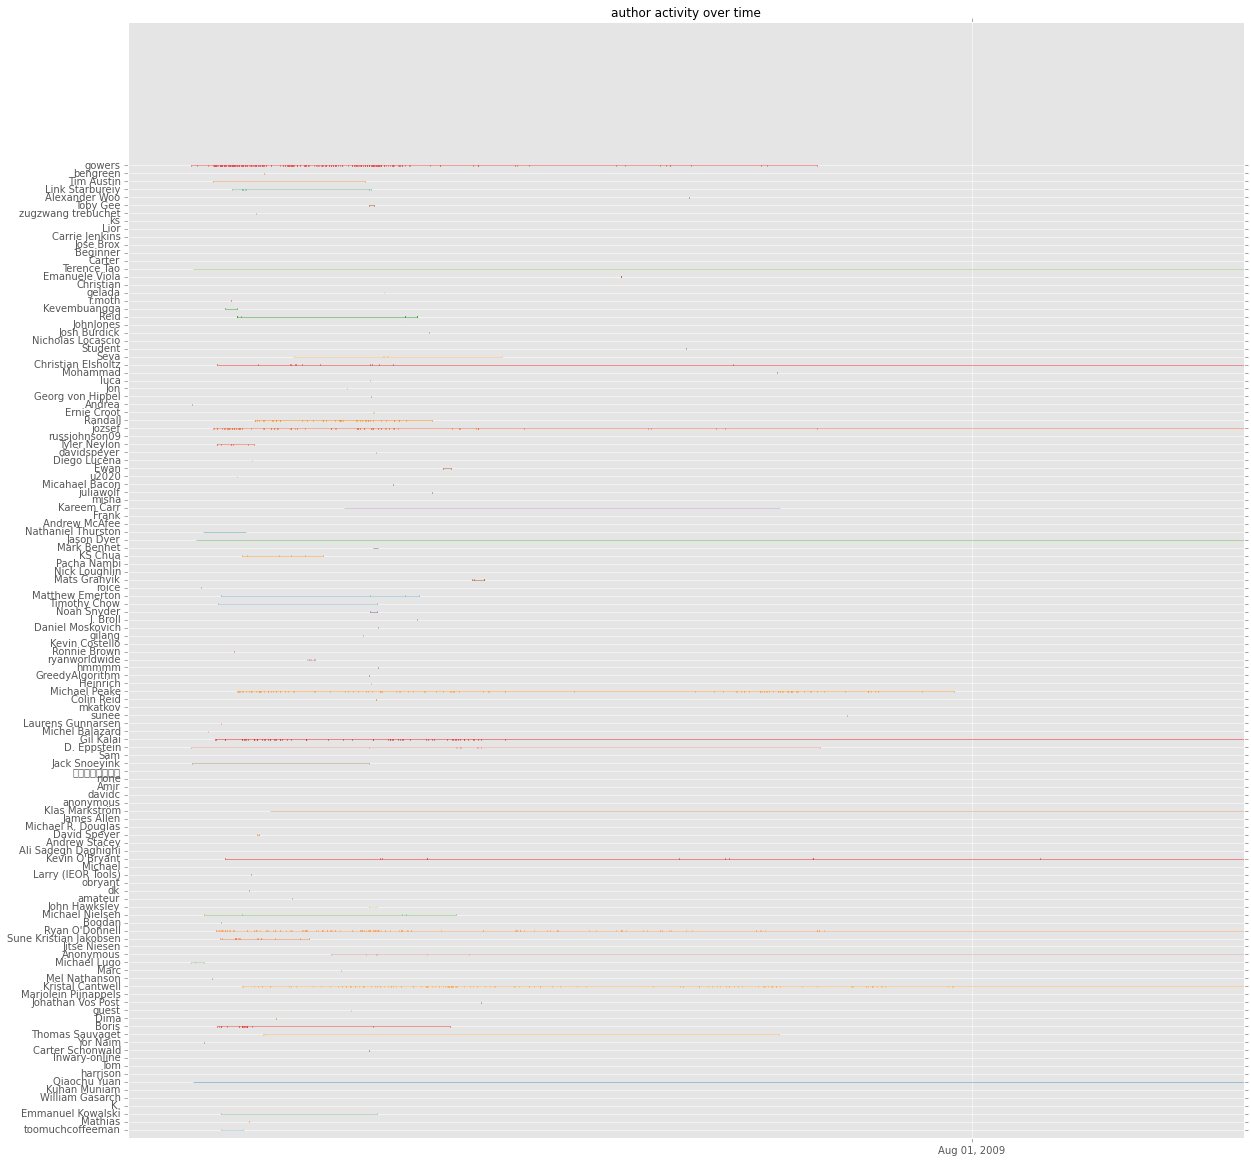

In [17]:
PM1_FRAME['mthread (accumulated)'].iloc[-1].plot_activity("author", max_span = timedelta(250), time_intervals=8)

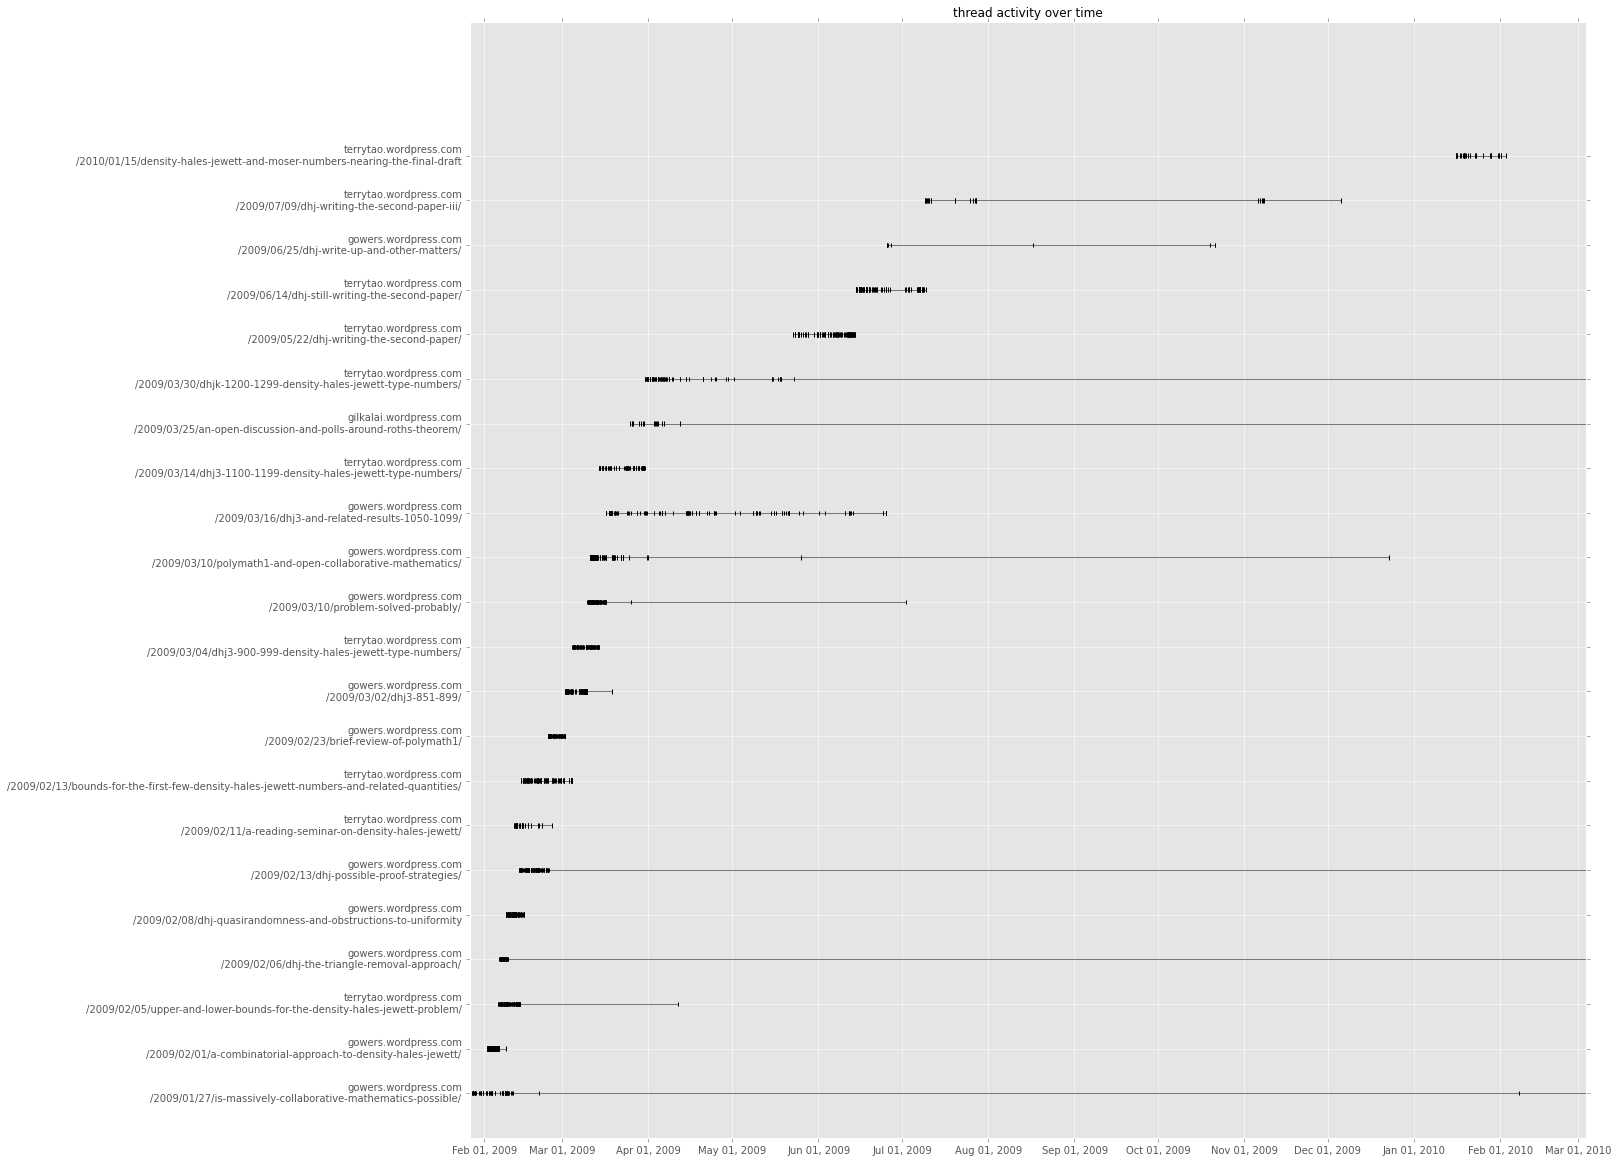

In [20]:
PM1_FRAME['mthread (accumulated)'].iloc[-1].plot_activity("thread", delta=timedelta(1), max_span = timedelta(400), time_intervals=1)

In [ ]:
01